# Transfer Learning!

Import all the things!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Bird Dataset

Our dataset is already stored in the folder `/kaggle/input/birds21wi`. We can set it up with torch as follows.

One thing to note, PyTorch will create internal class ids based on the ordering of classes in the folder (in alphabetical, not numerical order unfortunately). This means we have to create a backward mapping both to the original class ids and the class names.

In [2]:
def get_bird_data():
    transform_train = transforms.Compose([
        transforms.RandomRotation(15, resample=Image.BICUBIC, expand=False),
        transforms.Resize(256),# Resize to 256*256
        transforms.RandomCrop(256, padding=8, padding_mode='edge'), # Take 256*256 crops from padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ToTensor(),
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(256, padding_mode='edge'),# multi views from the image
        transforms.ToTensor(),
        #transforms.Lambda(lambda crops: torch.stack([ToTensor()(crop) for crop in crops]))
    ])
    trainset = torchvision.datasets.ImageFolder(root='/kaggle/input/birds21wi/birds/train', transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)

    testset = torchvision.datasets.ImageFolder(root='/kaggle/input/birds21wi/birds/test', transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
    
    classes = open("/kaggle/input/birds21wi/birds/names.txt").read().strip().split("\n")
    
    # Backward mapping to original class ids (from folder names) and species name (from names.txt)
    class_to_idx = trainset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data()

### Visualizing Bird Data

Just to make sure things make sense

torch.Size([8, 3, 256, 256])


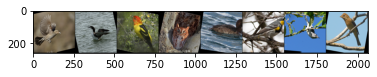

Labels:Red-winged Blackbird (Female/juvenile), Common Loon (Nonbreeding/juvenile), Western Tanager (Breeding Male), Eastern Screech-Owl, Greater Scaup (Female/Eclipse male), Yellow-rumped Warbler (Breeding Audubon's), Blue-gray Gnatcatcher, Lazuli Bunting (Female/juvenile)


In [3]:
dataiter = iter(data['train'])
images, labels = dataiter.next()
images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ', '.join('%9s' % data['to_name'][labels[j].item()] for j in range(8)))

## Training Code

Same as previous transfer learning notebook...

In [4]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            losses.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                  print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
    return losses

### Training ResNet

Use PyTorch's pretrained ResNet model. We change the last layer to fit our output size (555 classes) and train for 5 epochs at learning rate of 0.01.

In [5]:
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512, 555)

state = torch.load('/kaggle/input/checkpointpkl2/v2checkpoint-12.pkl')
losses = train(resnet, data['train'], epochs=23, state = state, schedule={0:.1, 5:.01, 18:.001}, checkpoint_path='./')

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Learning rate: 0.100000
Learning rate: 0.010000
[12,    10] loss: 0.352
[12,    20] loss: 0.313
[12,    30] loss: 0.325
[12,    40] loss: 0.333
[12,    50] loss: 0.324
[12,    60] loss: 0.332
[12,    70] loss: 0.321
[12,    80] loss: 0.328
[12,    90] loss: 0.353
[12,   100] loss: 0.359
[12,   110] loss: 0.349
[12,   120] loss: 0.343
[12,   130] loss: 0.350
[12,   140] loss: 0.327
[12,   150] loss: 0.327
[13,    10] loss: 0.316
[13,    20] loss: 0.307
[13,    30] loss: 0.299
[13,    40] loss: 0.301
[13,    50] loss: 0.322
[13,    60] loss: 0.323
[13,    70] loss: 0.309
[13,    80] loss: 0.310
[13,    90] loss: 0.307
[13,   100] loss: 0.307
[13,   110] loss: 0.293
[13,   120] loss: 0.311
[13,   130] loss: 0.314
[13,   140] loss: 0.294
[13,   150] loss: 0.309
[14,    10] loss: 0.286
[14,    20] loss: 0.280
[14,    30] loss: 0.289
[14,    40] loss: 0.271
[14,    50] loss: 0.308
[14,    60] loss: 0.277
[14,    70] loss: 0.282
[14,    80] loss: 0.296
[14,    90] loss: 0.299
[14,   100] loss

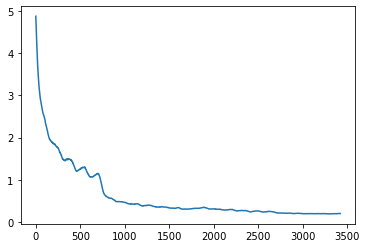

In [6]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

plt.plot(smooth(losses,50))

## Make Our Predictions!

We'll predict for all 10,000 images in the test set. Remember we need to use our inverse mapping from to get back to the original class ids.

In [7]:
def predict(net, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], data['to_class'][predicted.item()]))
    out.close()

In [8]:
for i in range(10):
    predict(resnet, data['test'], "preds" + str(i)+".csv")
         

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
0
100
200
300
400
500
60